# metrics for classification

**Task** - Determining the right thresholds/decision boundaries between the three classes (undamaged/repair/replace)

In [1]:
import numpy as np 
import pandas as pd
import glob
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')

# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', 1000, 'display.max_columns', None)

# Plotting options
%matplotlib inline
mp.style.use('ggplot')
sns.set(style='whitegrid')

# Sklearn classification model evaluation functions
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, f1_score

In [2]:
### Load all metadata
path = r'input/metadata' 
all_files = glob.glob(path + "/*.csv.gz")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, compression='gzip',header=0, sep=',', quotechar='"')
    li.append(df)

claims = pd.concat(li, axis=0, ignore_index=True)

In [3]:
claims.head(2)

,claim_id,make,model,year,poi,line_num,part,operation,part_price,labour_amt
0,7535,Peugeot,406,2004.0,Front Right,1,fbumper,replace,1061.609985,130.000001
1,2643,Ford,C-max,2008.0,Rear Centre,1,bbumper,repair,NaN,195.000000


In [4]:
### General info of metadata
print('Total number of the line item: ' + str(claims.shape[0]))
print('No. of Unique Customers: ' + str(claims.claim_id.nunique()))

Total number of the line item: 199827
No. of Unique Customers: 94544


In [5]:
### Load Classifier Output
classifier = pd.read_csv('input/classifier_output.csv')

In [6]:
classifier.head(2)

,claim_id,part,urr_score,set
0,0,fbumper,0.464102,0
1,0,bbumper,0.680342,0


In [7]:
### General info of Classifier
print('No. of Unique Customers: ' + str(classifier.claim_id.nunique()))

No. of Unique Customers: 100000


In [8]:
total = classifier.merge(claims, how = 'left', on =['claim_id', 'part']) 
total.dropna(subset=['urr_score'], inplace=True)

In [9]:
### General info of merged data
print('Total number of claims: ' + str(total.shape[0]))
print('No. of Unique Customers: ' + str(total.claim_id.nunique()))

Total number of claims: 682424
No. of Unique Customers: 99957


In [10]:
total.operation.value_counts(dropna=False)

NaN        491232
repair     131609
replace     59583
Name: operation, dtype: int64

In [11]:
total['operation'] = total['operation'].fillna('undamaged') # replace operation by undamaged if no records in metadata

In [12]:
train = total[total.set == 0]
val = total[total.set == 1]
test = total[total.set == 2]

#### 1. Analyse the performance of the classifiers

In [13]:
df = train

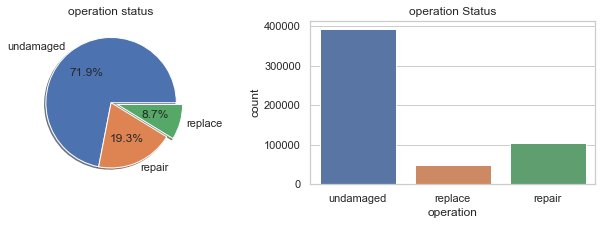

In [14]:
f,ax=plt.subplots(1,2,figsize=(10,3))
df['operation'].value_counts().plot.pie(explode=[0,0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('operation status')
ax[0].set_ylabel('')

sns.countplot('operation',data=df,ax=ax[1])
ax[1].set_title('operation Status')
plt.show()

**Finding**: 
- undamaged:replace:repair=7:2:1
- label is unbalanced

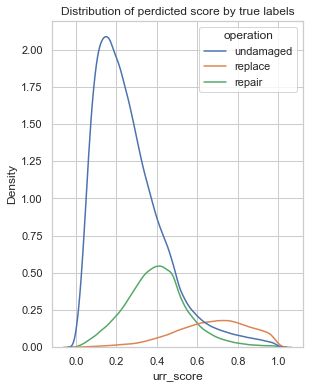

In [15]:
f,ax=plt.subplots(figsize=(4,6)) 
sns.kdeplot(data=df, x='urr_score', hue='operation')
ax.set_title('Distribution of perdicted score by true labels')
#ax.set_ylabel('')
plt.show()

**Finding**: 
- Ideally, the smaller the overlap between three group, the higher the discrimination power
- Due to the unbalanced data, especially the high proportion of undamaged, the ovelapping is quite high, however, we can easily see that there is a right shift of score distribution for three groups. 

In [16]:
def percentile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'percentile_{:2.0f}'.format(n*100)
    return percentile_

In [17]:
# summry table of urr_score by operation decision
df.groupby('operation')['urr_score'].agg(['count', np.mean, np.std, np.min, percentile(0.25), np.median, percentile(0.75), np.max])

,count,mean,std,amin,percentile_25,median,percentile_75,amax
operation,,,,,,,,
repair,105422,0.401017,0.154586,6.198883e-06,0.299719,0.397462,0.488977,0.999236
replace,47773,0.666111,0.186892,5.297899e-03,0.545761,0.683678,0.807491,0.999491
undamaged,392799,0.266627,0.170753,1.192093e-07,0.140393,0.230525,0.353738,0.999923


**Finding**: 
- From the percentil, we can easily found that score perform well to differentiate three groups.

### 2. Find the optimum thresholds

To define the threshold for three groups (undamaged/repair/replace classes), two extra labels were generated so that the threshold is calculated through ONE V.S. Others
- is_damaged: whether the part is damaged
- is_replace: whether the part need to be replaced

In [18]:
df['is_damaged'] = (df['operation'] != 'undamaged').apply(np.uint8)
df['is_replace'] = (df['operation'] == 'replace').apply(np.uint8)

**Metthod 1**  - ROC & G-MEAN

In [19]:
# Define a function to plot the ROC/AUC
def plotRocAuc(y_true, y_pred):
    '''
    
    ----------------------------------------------------------------------
    :param y_true:  true label.
    :param y_pred: prdeicted pd.
    ----------------------------------------------------------------------
    :return roc plot
    ----------------------------------------------------------------------

    '''
 
    
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)    # Compute the ROC curve
    plt.plot([0, 1], [0, 1], linestyle='--') # Plot the "dumb model" line
    plt.plot(fpr, tpr, marker='.') # Plot the model line
    plt.text(0.75, 0.25, "AUC: " + str(round(roc_auc_score(y_true, y_pred),2)))
    plt.show()

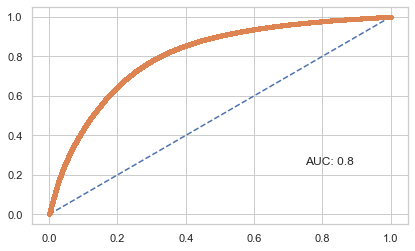

In [20]:
plotRocAuc(df['is_damaged'], df['urr_score'])

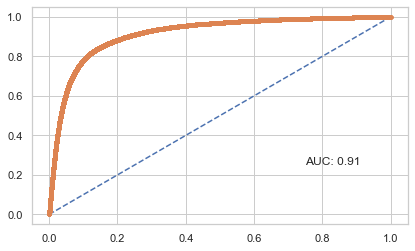

In [21]:
plotRocAuc(df['is_replace'], df['urr_score'])

**Finding**: 
- AUC is 0.8, means that a randomly selected case from the group with the target equals 1 has a score larger than that for a randomly chosen case from the group with the target equals 0 in 80% of the time. 
- Classifier performs very well to distinguish between two groups, especially at replaced v.s. others. 

In [22]:
def thresholdGmean(y_true, y_pred):
    '''
    
    '''
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thresholds})
    df_fpr_tpr.head()
    gmean = np.sqrt(tpr * (1 - fpr))
    
    # Find the optimal threshold
    index = np.argmax(gmean)
    thresholdOpt = round(thresholds[index], ndigits = 4)
    
    return thresholdOpt

In [23]:
thresholdGmean(df['is_damaged'], df['urr_score'])

0.3274

In [24]:
thresholdGmean(df['is_replace'], df['urr_score'])

0.4806

**Method 2** KS Plot

In [25]:
# define a function to plot KS to decide the threshold
def KS(score_df, score, y):
    '''
    
    ----------------------------------------------------------------------
    :param score_df:  dataframe.
    :param score: prdeicted pd.
    :y: true label
    ----------------------------------------------------------------------
    :return score_df.loc[:, ['tpr', 'fpr', 'ks']]: dataframe, tpr and fpr for each score
    ----------------------------------------------------------------------

    '''
    score_df = score_df.sort_values(by = score, ascending = False)
    total_bad = score_df[y].sum()
    total_good = score_df.shape[0] - total_bad
    score_df = pd.crosstab(index = score_df[score], columns = score_df[y]).fillna(0) # regarding the score as threshold, calculate the number of positive and negative 
    score_df['tpr'] = score_df[1].cumsum() / total_bad #calculate tpr
    score_df['fpr'] = score_df[0].cumsum() / total_good #calculate fpr
    score_df['ks'] = abs(score_df.tpr - score_df.fpr) #calculate ks
    max_ks = score_df.ks.max() #take the maximal value of ks
    max_ks_score = score_df[score_df.ks == max_ks].index.values[0] #take the score which achieve the maximal KS
    score_df.tpr.plot(label = 'tpr', c = 'red')
    score_df.fpr.plot(label = 'fpr', c = 'green')
    score_df.ks.plot(label = 'ks', c = 'black')
    plt.text(max_ks_score, max_ks, s = f'{max_ks_score:.2f}, {max_ks:.4f}')
    plt.legend()
    plt.show()
    
    return score_df.loc[:, ['tpr', 'fpr', 'ks']]


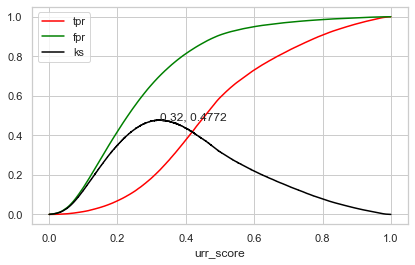

In [26]:
ks_df = KS(df, 'urr_score', 'is_damaged')

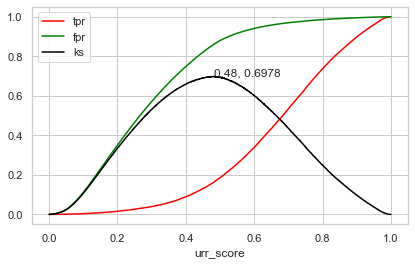

In [27]:
ks_df = KS(df, 'urr_score', 'is_replace')

**Finding**: 
- K-S or Kolmogorov-Smirnov chart measures performance of classification models. More accurately, K-S is a measure of the degree of separation between the positive and negative distributions. The K-S is 100 if the scores partition the population into two separate groups in which one group contains all the positives and the other all the negatives. On the other hand, If the model cannot differentiate between positives and negatives, then it is as if the model selects cases randomly from the population. The K-S would be 0. In most classification models the K-S will fall between 0 and 100, and that the higher the value the better the model is at separating the positive from negative cases.

- K-S fomular: max(|cum_bad_rate - cum_good_rate|)
 
- To sepearte damaged from undamaged, we select threshold as 0.32, which can achieve decent discrimination power with k-s equals to 48%
- To sepearte replaced from others, we select threshold as 0.48, which can achieve very good discrimination power with k-s equals to 69%

- The threshold from KS-plot and G-MEAN are very close, as they both consider TPR and FPR 


**Method 3** Precision Recall Plot & F1 score

In [28]:
def thresholdF1(y_true, y_pred):
    '''
    
    
    '''
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    df_recall_precision = pd.DataFrame({'Precision':precision[:-1],
                                        'Recall':recall[:-1],
                                        'Threshold':thresholds})

    # Calculate the f-score
    fscore = (2 * precision * recall) / (precision + recall)
    
    # Find the optimal threshold
    index = np.nanargmax(fscore)
    thresholdOpt = round(thresholds[index], ndigits = 4)
    fscoreOpt = round(fscore[index], ndigits = 4)
    
    return thresholdOpt, fscoreOpt

In [29]:
thresholdF1(df['is_damaged'], df['urr_score'])

(0.3384, 0.6111)

In [30]:
thresholdF1(df['is_replace'], df['urr_score'])

(0.5995, 0.5806)

**Finding**: 
- Precison-Recall look at TPR and PPR, which a better measurement for imbalanced data

- The threshold is higher for replaced

### 3. Check Performace

In [31]:
# generate predicted label by defined threshold (KS)
df['pred_label'] = np.where(df.urr_score<=0.32, 0, np.where((df.urr_score>0.32) & (df.urr_score<=0.48), 1, 2))

# convert true label as numeric 
lookup = {"undamaged":0, "repair":1, "replace":2}
df['true_label'] = df['operation'].map(lookup)

In [32]:
# classfication report
target_names = ['undamaged', 'repair', 'replace']
print(classification_report(df['true_label'], df['pred_label'], target_names=target_names))

              precision    recall  f1-score   support

   undamaged       0.89      0.69      0.78    392799
      repair       0.35      0.43      0.39    105422
     replace       0.36      0.84      0.51     47773

    accuracy                           0.66    545994
   macro avg       0.54      0.66      0.56    545994
weighted avg       0.74      0.66      0.68    545994



In [33]:
def processing(df, cutoff1, cutoff2):
    '''
    
    Apply same processing on train, val and test data
    
    '''
    df['is_damaged'] = (df['operation'] != 'undamaged').apply(np.uint8)
    df['is_replace'] = (df['operation'] == 'replace').apply(np.uint8)
    
    df['pred_label'] = np.where(df.urr_score<=cutoff1, 0, np.where((df.urr_score>cutoff1) & (df.urr_score<=cutoff2), 1, 2))
    
    lookup = {"undamaged":0, "repair":1, "replace":2}
    df['true_label'] = df['operation'].map(lookup)
    
    return df


In [34]:
# Threshold by ROC
train_1 = processing(train, 0.32, 0.48)
val_1 = processing(val, 0.32, 0.48)
test_1 = processing(test, 0.32, 0.48)

In [35]:
target_names = ['undamaged', 'repair', 'replace']

In [36]:
# classfication report on training table
print(classification_report(train_1['true_label'], train_1['pred_label'], target_names=target_names))

              precision    recall  f1-score   support

   undamaged       0.89      0.69      0.78    392799
      repair       0.35      0.43      0.39    105422
     replace       0.36      0.84      0.51     47773

    accuracy                           0.66    545994
   macro avg       0.54      0.66      0.56    545994
weighted avg       0.74      0.66      0.68    545994



In [37]:
# classfication report on validation table
print(classification_report(val_1['true_label'], val_1['pred_label'], target_names=target_names))

              precision    recall  f1-score   support

   undamaged       0.89      0.69      0.78     49045
      repair       0.34      0.43      0.38     12989
     replace       0.35      0.82      0.49      5961

    accuracy                           0.65     67995
   macro avg       0.53      0.65      0.55     67995
weighted avg       0.74      0.65      0.68     67995



In [38]:
# classfication report on test table
print(classification_report(test_1['true_label'], test_1['pred_label'], target_names=target_names))

              precision    recall  f1-score   support

   undamaged       0.89      0.69      0.78     49388
      repair       0.34      0.43      0.38     13198
     replace       0.35      0.81      0.49      5849

    accuracy                           0.65     68435
   macro avg       0.53      0.64      0.55     68435
weighted avg       0.74      0.65      0.68     68435



In [39]:
# Threshold by precision-recall
train_2 = processing(train, 0.34, 0.60)
val_2 = processing(val, 0.34, 0.60)
test_2 = processing(test, 0.34, 0.60)

In [40]:
# classfication report on training table
print(classification_report(train_2['true_label'], train_2['pred_label'], target_names=target_names))

              precision    recall  f1-score   support

   undamaged       0.88      0.73      0.80    392799
      repair       0.37      0.56      0.45    105422
     replace       0.52      0.66      0.58     47773

    accuracy                           0.69    545994
   macro avg       0.59      0.65      0.61    545994
weighted avg       0.75      0.69      0.71    545994



In [41]:
# classfication report on validation table
print(classification_report(val_2['true_label'], val_2['pred_label'], target_names=target_names))

              precision    recall  f1-score   support

   undamaged       0.88      0.72      0.79     49045
      repair       0.36      0.57      0.44     12989
     replace       0.50      0.62      0.55      5961

    accuracy                           0.68     67995
   macro avg       0.58      0.64      0.59     67995
weighted avg       0.75      0.68      0.70     67995



In [42]:
# classfication report on test table
print(classification_report(test_2['true_label'], test_2['pred_label'], target_names=target_names))

              precision    recall  f1-score   support

   undamaged       0.88      0.72      0.79     49388
      repair       0.36      0.56      0.44     13198
     replace       0.49      0.62      0.55      5849

    accuracy                           0.68     68435
   macro avg       0.58      0.63      0.59     68435
weighted avg       0.75      0.68      0.70     68435



**Finding**: 
- recall(TPR) is best for replace, follwed by undamaged, then repair, as repair has large overlapping with undmaged and replace
- Precision measures how often it is correct if the prediction is yes, low for repair and replace, which indicates a detected damage might not be real damage
- F1-score is a combination of recall and precision, which is a good metric for unbalanced data
- macro avg F1 treats all classes eqaully, the value is 0.55 as affected by the minority class
- weighted avg F1 treats each class differentely, the value is 0.68, slightly higher macro avg F1, as it gives higher weight on the majority class


#### 4. Threshold tuning

In [43]:
# Array for finding the optimal threshold
thresholds = np.arange(0.0, 1.0, 0.01)
fscore = np.zeros(shape=(len(thresholds)))
print('Length of sequence: {}'.format(len(thresholds)))

# Fit the model
for index, elem in enumerate(thresholds):
    y_pred_prob = (df['urr_score'] > elem).astype('int')
    fscore[index] = f1_score(df['is_replace'], y_pred_prob)

# Find the optimal threshold
index = np.nanargmax(fscore)
thresholdOpt = round(thresholds[index], ndigits = 4)
fscoreOpt = round(fscore[index], ndigits = 4)
print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))

# Plot the threshold tuning
df_threshold_tuning = pd.DataFrame({'F-score':fscore,
                                    'Threshold':thresholds})
df_threshold_tuning.head()

Length of sequence: 100
Best Threshold: 0.6 with F-Score: 0.5805


,F-score,Threshold
0,0.160915,0.00
1,0.161134,0.01
2,0.161492,0.02
3,0.162089,0.03
4,0.162978,0.04


In [44]:
df_threshold_tuning.columns

Index(['F-score', 'Threshold'], dtype='object')